In [2]:
import os
import json
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
from compute_tempo import *

def extract_dance_onset(sensor_data, T_filter=0.25, 
                        smooth_wlen= 10, pk_order = 30,
                        remove_pk_thres=0.10, height_thres=0.2,
                        mov_avg_winsz = 10, fps =60,
                        vel_mode="off", mode = "zero_uni"):
    # to used for any combincation of two sensors or two body markers
    sensor_dir_change = None
    sensor_onsets = None

    if mode == 'zero_uni':          # Extract uni-directional change onsets
        
        sensor_abs_pos = smooth_velocity(sensor_data, abs="no", window_length = smooth_wlen, polyorder = 0) # size (n, 3)
        if vel_mode == "on":
            sensor_abs_pos = np.diff(sensor_abs_pos, axis=0)    # velocity
        
        sensor_abs_pos[sensor_abs_pos < 0] = 0
        
        sensor_abs_pos_norm = min_max_normalize_1D(sensor_abs_pos.flatten())     # normalize 0-1
        sensor_dir_change = velocity_based_novelty(sensor_abs_pos_norm.reshape(-1,1), height = height_thres, distance=15)    # size (n, 3)
        
        sensor_onsets = filter_dir_onsets_by_threshold(sensor_dir_change, threshold_s= T_filter, fps=fps)
        sensor_onsets_50ms = binary_to_peak(sensor_onsets, peak_duration=0.05)
  

    elif mode == 'zero_bi':         # Extract bi-directional change onsets
        
        sensor_abs_pos = smooth_velocity(sensor_data, abs="yes", window_length = smooth_wlen, polyorder = 0) # size (n, 3)
        if vel_mode == "on":
            sensor_abs_pos = np.diff(sensor_abs_pos, axis=0)   # velocity
        
        sensor_abs_pos_norm = min_max_normalize_1D(sensor_abs_pos.flatten())
        sensor_dir_change = velocity_based_novelty(sensor_abs_pos_norm.reshape(-1,1), height = height_thres, distance=15)    # size (n, 3)
        
        sensor_onsets = filter_dir_onsets_by_threshold(sensor_dir_change, threshold_s= T_filter, fps=fps)
        sensor_onsets_50ms = binary_to_peak(sensor_onsets, peak_duration=0.05)

    json_data = {
        "raw_signal": sensor_data,
        "sensor_abs": sensor_abs_pos,   # array
        'sensor_abs_pos_norm': sensor_abs_pos_norm,
        
        "sensor_dir_change_onsets": sensor_dir_change,  # array
        "sensor_onsets": sensor_onsets,     # array
        "sensor_onsets_50ms": sensor_onsets_50ms,     # array
        
        
    }
    return json_data

def min_max_normalize_1D(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [3]:

import os
import json
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
from compute_tempo import *

marker_dict = {9: "left_wrist", 10: "right_wrist", 
                15: "left_ankle", 16: "right_ankle", 
                }   # 11: "left_hip",12: "right_hip"

mode = "zero_uni"   # zero_bi
markerA_id = 9     # left wrist
h_thres = 0.2
vel_mode = "off"
# def extract_body_onsets(mode, markerA_id, savepath, h_thres = 0.2, vel_mode = "off"):

fps = 60
f_path = "./aist_dataset/aist_annotation/keypoints2d"
aist_filelist = os.listdir(f_path)

skipped_list = []
for idx, filename in enumerate(tqdm(aist_filelist)):
    
    file_path = os.path.join(f_path, filename)
    
    with open(file_path, 'rb') as file:
        motion_data = pickle.load(file)

    markerA_x = motion_data["keypoints2d"][0, :, markerA_id, 0]     # array (n,)
    markerA_y = motion_data["keypoints2d"][0, :, markerA_id, 1]      # array (n,)
    
    if np.all((markerA_x == 0) & (markerA_y == 0)) or np.any(np.isnan(markerA_x) | np.isnan(markerA_y)):
        skipped_list.append(filename)
        continue
    
    markerA_x = detrend_signal_array(markerA_x.reshape(-1, 1), cutoff= 1, fs=60)
    markerA_y = detrend_signal_array(markerA_y.reshape(-1, 1), cutoff= 1, fs=60)
    markerA_pos = np.concatenate((markerA_x, markerA_y), axis=1)  # size (n,2)
    
    
    for ax in range(2):
        
        # z-score
        mean_x = np.mean(markerA_pos[:, ax])
        std_x = np.std(markerA_pos[:, ax])
        
        markerA_pos_norm = (
        (markerA_pos[:, ax] - mean_x) / std_x if std_x != 0 else np.zeros_like(markerA_pos[:, ax])
        )

        markerA_ax = markerA_pos_norm.reshape(-1,1)
            
        
        bodysegment_onsets_data = extract_dance_onset(markerA_ax, T_filter=0.25, 
                                                        smooth_wlen= 10, pk_order = 15, 
                                                        remove_pk_thres=0.10, height_thres=h_thres,
                                                        mov_avg_winsz = 10, fps = fps,
                                                        vel_mode= vel_mode, mode = mode)
        break
    break

# "raw_signal": sensor_data,
# "sensor_abs": sensor_abs_pos,   # array
# 'del_energy_norm': del_energy_norm,
# "sensor_abs_pos_filtered": del_energy_movavg,   # array
# "sensor_dir_change_onsets": sensor_dir_change,  # array
# "sensor_onsets": sensor_onsets,     # array
# "sensor_onsets_50ms": sensor_onsets_50ms,     # array
# from scipy.signal import savgol_filter
# smoothed = savgol_filter(markerA_ax[:, 0], 60, 0)



  0%|          | 0/1510 [00:00<?, ?it/s]


In [ ]:
from scipy.signal import find_peaks
# peaks_indices = find_peaks(bodysegment_onsets_data['sensor_abs_pos_norm'], height=0.1, distance=15)[0]

plt.figure(figsize=(12, 8), dpi=200)
time = np.arange(len(markerA_ax)) / fps
plt.plot(bodysegment_onsets_data['raw_signal'], label='Raw Signal')




# plt.plot(bodysegment_onsets_data['sensor_dir_change_onsets'])
# plt.plot(bodysegment_onsets_data['sensor_onsets'])
# plt.plot(bodysegment_onsets_data['sensor_onsets_50ms'])

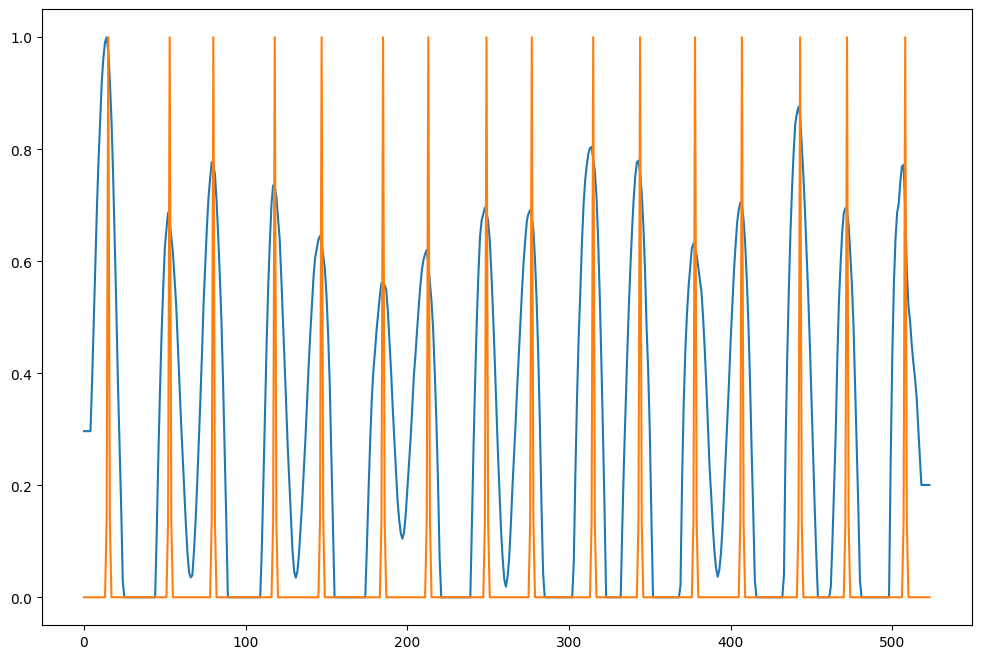

In [5]:
plt.figure(figsize=(12, 8))
time = np.arange(len(markerA_ax)) / fps
# plt.plot(bodysegment_onsets_data['sensor_abs'])
plt.plot(bodysegment_onsets_data['sensor_abs_pos_norm'])
# plt.plot(bodysegment_onsets_data['sensor_dir_change_onsets'])
# plt.plot(bodysegment_onsets_data['sensor_onsets'])
plt.plot(bodysegment_onsets_data['sensor_onsets_50ms'])

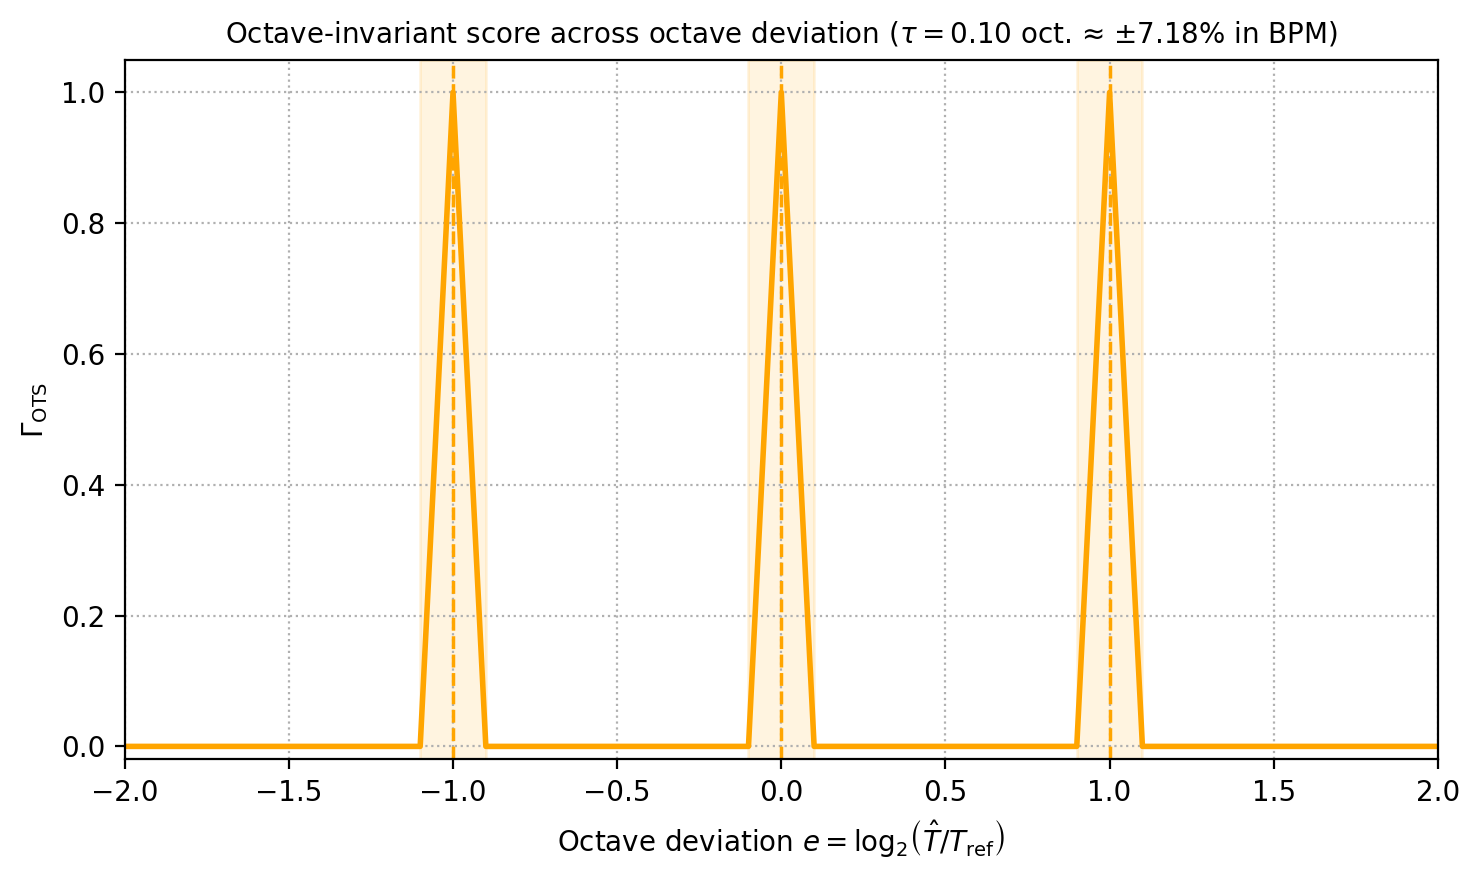

In [9]:
# Figure 1: Octave-invariant tempo score Γ_OTS vs. octave deviation e
# Dependencies: numpy, matplotlib

import numpy as np
import matplotlib.pyplot as plt

def gamma_ots_from_e(e, tau=0.10, k_levels=(-1, 0, +1)):
    """
    Compute Γ_OTS directly in the octave domain.

    Parameters
    ----------
    e : array-like
        Octave deviation values, e = log2(ĤT / T_ref).
    tau : float
        Tolerance in octaves (default 0.10).
    k_levels : tuple of ints
        Permissible metrical levels (half, original, double time).

    Returns
    -------
    gamma : np.ndarray
        Γ_OTS(e) = 1 - min(d, tau)/tau, clipped to [0, 1],
        where d = min_k |e - k|.
    """
    e = np.asarray(e, dtype=float)
    K = np.array(k_levels, dtype=float).reshape(1, -1)
    d = np.min(np.abs(e.reshape(-1, 1) - K), axis=1)
    gamma = 1.0 - np.minimum(d, tau) / tau
    return np.clip(gamma, 0.0, 1.0)

def main():
    # Parameters for the plot
    tau = 0.10                      # tolerance in octaves (≈ ±7.18% in BPM)
    k_levels = (-1, 0, +1)          # half-time, original, double-time
    e_vals = np.linspace(-2.0, 2.0, 2001)

    # Compute Γ_OTS(e)
    gamma_vals = gamma_ots_from_e(e_vals, tau=tau, k_levels=k_levels)

    # Plot
    fig = plt.figure(figsize=(7.5, 4.5), dpi=200)
    ax = plt.gca()
    ax.plot(e_vals, gamma_vals, linewidth=2.0, color='orange')

    # Mark permissible metrical levels and tolerance bands
    for k in k_levels:
        ax.axvline(k, linestyle='--', linewidth=1.25, color = "orange")
        ax.axvspan(k - tau, k + tau, alpha=0.12, color = "orange")
        # ax.text(k, 1.02, f"{k:+d}", ha='center', va='bottom', fontsize=10, clip_on=False)

    # Axes, labels, and title
    ax.set_xlim(-2.0, 2.0)
    ax.set_ylim(-0.02, 1.05)
    ax.set_xlabel(r"Octave deviation $e = \log_{2}\!\left(\hat{T}/T_{\mathrm{ref}}\right)$")
    ax.set_ylabel(r"$\Gamma_{\mathrm{OTS}}$")
    ax.set_xticks([-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2])
    ax.grid(True, which='both', linestyle=':')
    pct = (2**tau - 1.0) * 100.0
    ax.set_title(rf"Octave-invariant score across octave deviation ($\tau={tau:.2f}$ oct. ≈ ±{pct:.2f}% in BPM)", fontsize=10)

    fig.tight_layout()

    # Uncomment to save to disk
    # fig.savefig("ots_vs_octave_deviation.png", bbox_inches="tight")
    # fig.savefig("ots_vs_octave_deviation.pdf", bbox_inches="tight")

    plt.show()

if __name__ == "__main__":
    main()


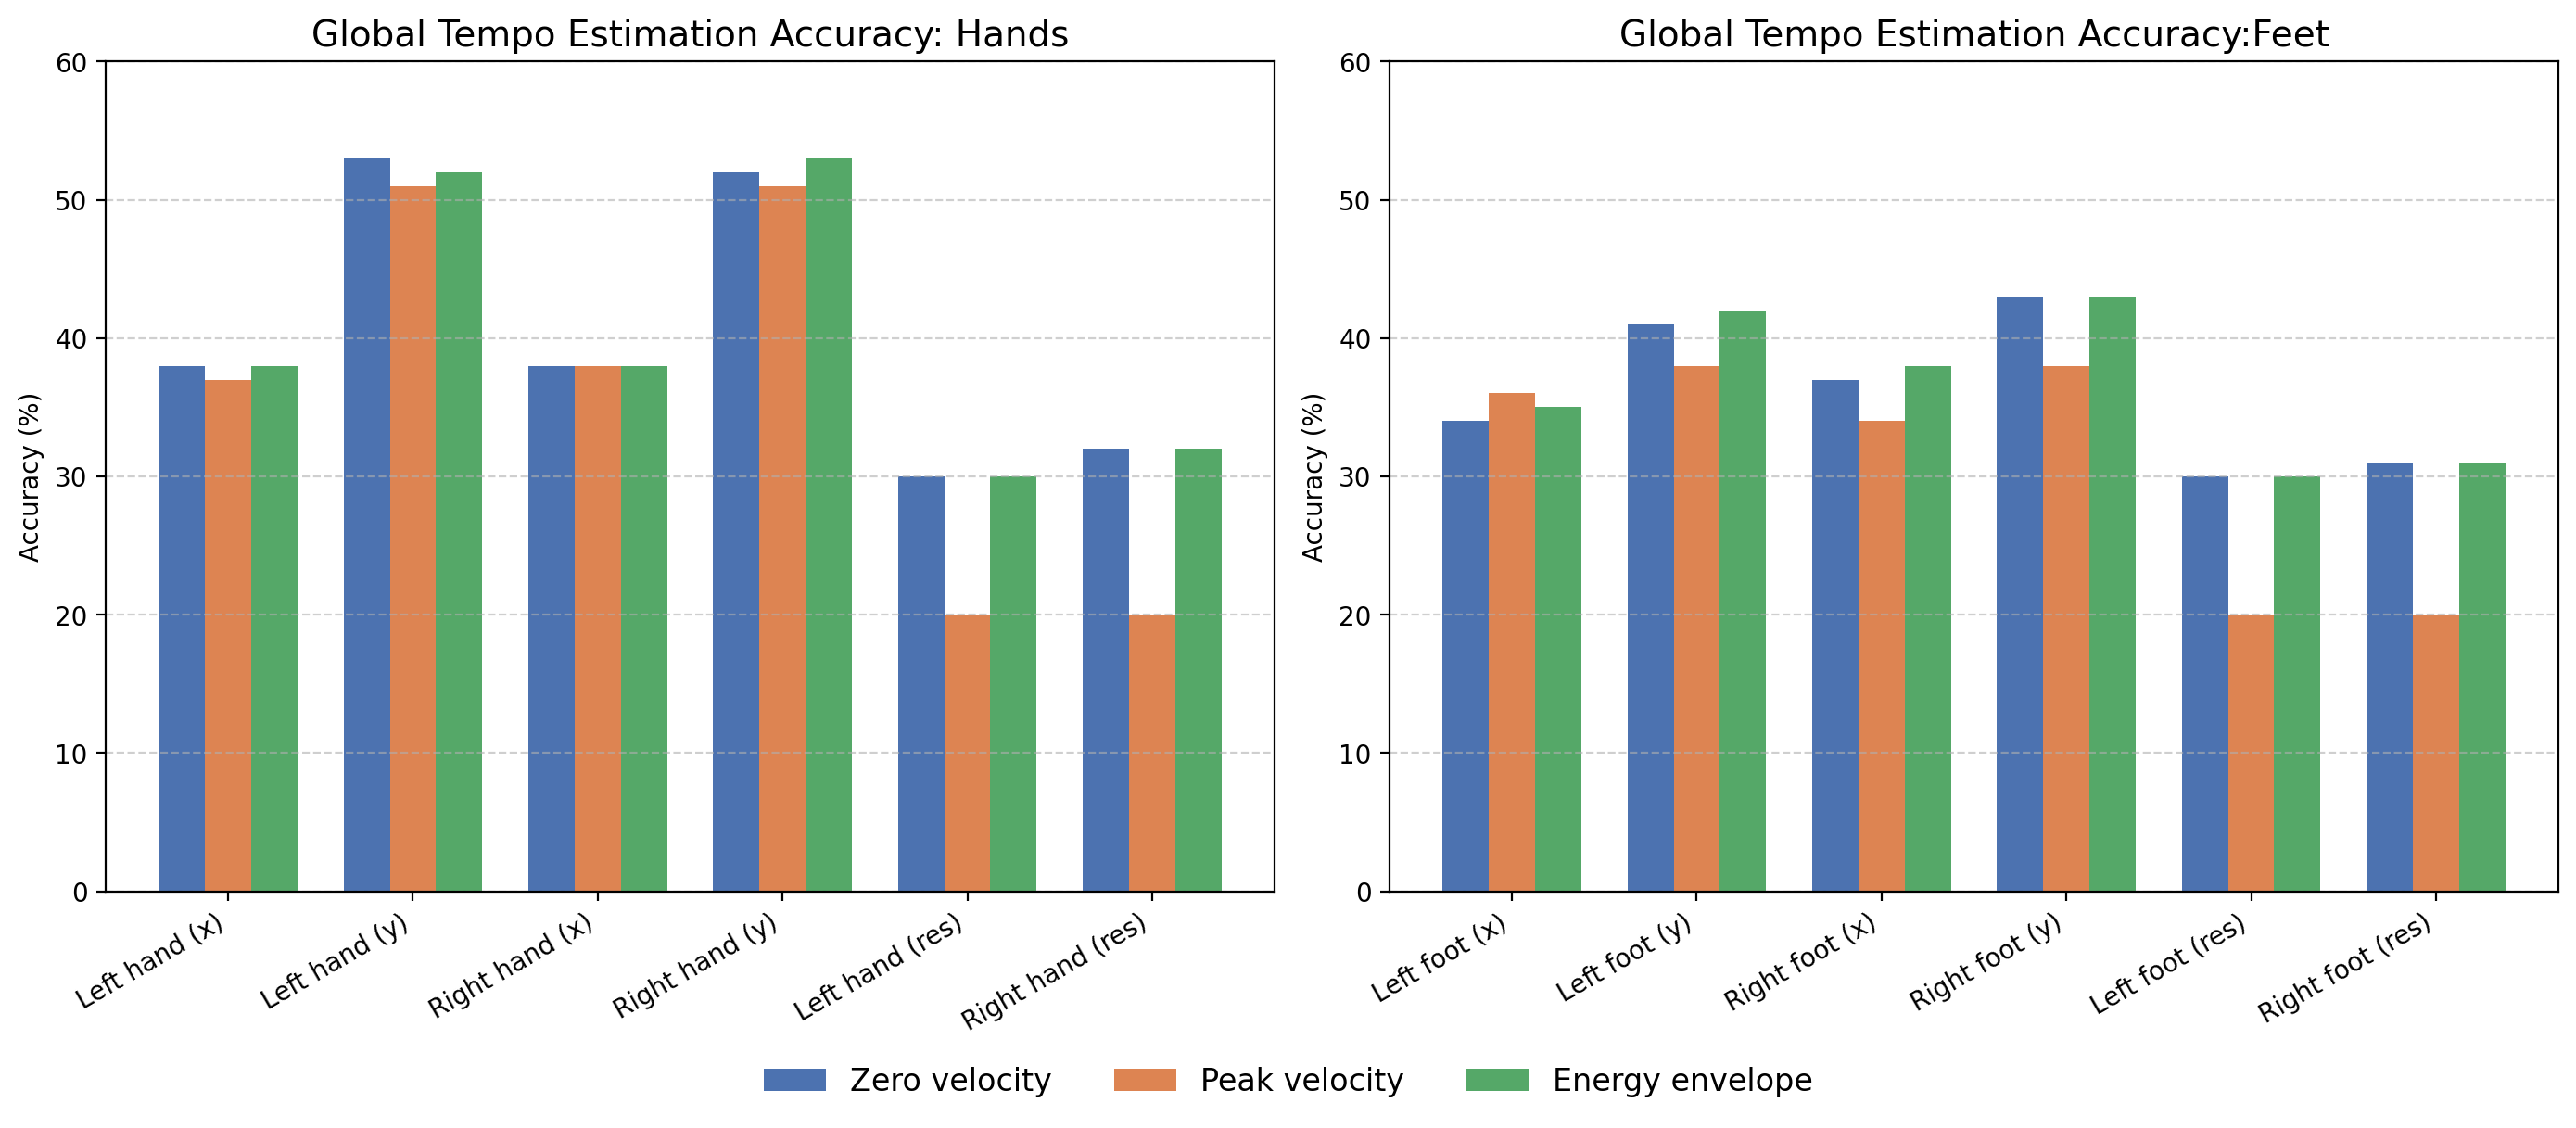

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# ==== Data ====

segments_hands = [
    "Left hand (x)", "Left hand (y)",
    "Right hand (x)", "Right hand (y)",
    "Left hand (res)", "Right hand (res)"
]

segments_feet = [
    "Left foot (x)", "Left foot (y)",
    "Right foot (x)", "Right foot (y)",
    "Left foot (res)", "Right foot (res)"
]

# Uni-directional (%) results
zero_uni_hands = [38, 53, 38, 52, 30, 32]
peak_uni_hands = [37, 51, 38, 51, 20, 20]
energy_uni_hands = [38, 52, 38, 53, 30, 32]

zero_uni_feet = [34, 41, 37, 43, 30, 31]
peak_uni_feet = [36, 38, 34, 38, 20, 20]
energy_uni_feet = [35, 42, 38, 43, 30, 31]

# ==== Plot settings ====

def plot_individual_segment(ax, segments, zero, peak, energy, title):
    x = np.arange(len(segments))
    width = 0.25

    ax.bar(x - width, zero, width, label='Zero velocity', color='#4C72B0')
    ax.bar(x, peak, width, label='Peak velocity', color='#DD8452')
    ax.bar(x + width, energy, width, label='Energy envelope', color='#55A868')

    ax.set_title(title, fontsize=14, )
    ax.set_xticks(x)
    ax.set_xticklabels(segments, rotation=30, ha='right')
    ax.set_ylim(0, 60)
    ax.set_ylabel('Accuracy (%)')
    ax.grid(axis='y', linestyle='--', alpha=0.6)

# ==== Figure ====
fig = plt.figure(figsize=(14, 6), dpi=200)

ax1 = plt.subplot(1, 2, 1)
plot_individual_segment(ax1, segments_hands, zero_uni_hands, peak_uni_hands, energy_uni_hands,
                        'Global Tempo Estimation Accuracy: Hands')

ax2 = plt.subplot(1, 2, 2)
plot_individual_segment(ax2, segments_feet, zero_uni_feet, peak_uni_feet, energy_uni_feet,
                        'Global Tempo Estimation Accuracy:Feet')

plt.tight_layout()
# plt.legend(bbox_to_anchor=(1.05, 1), loc='best')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, frameon=False, bbox_to_anchor=(0.5, -0.02), fontsize=12)
fig.subplots_adjust(bottom=0.19)
plt.show()


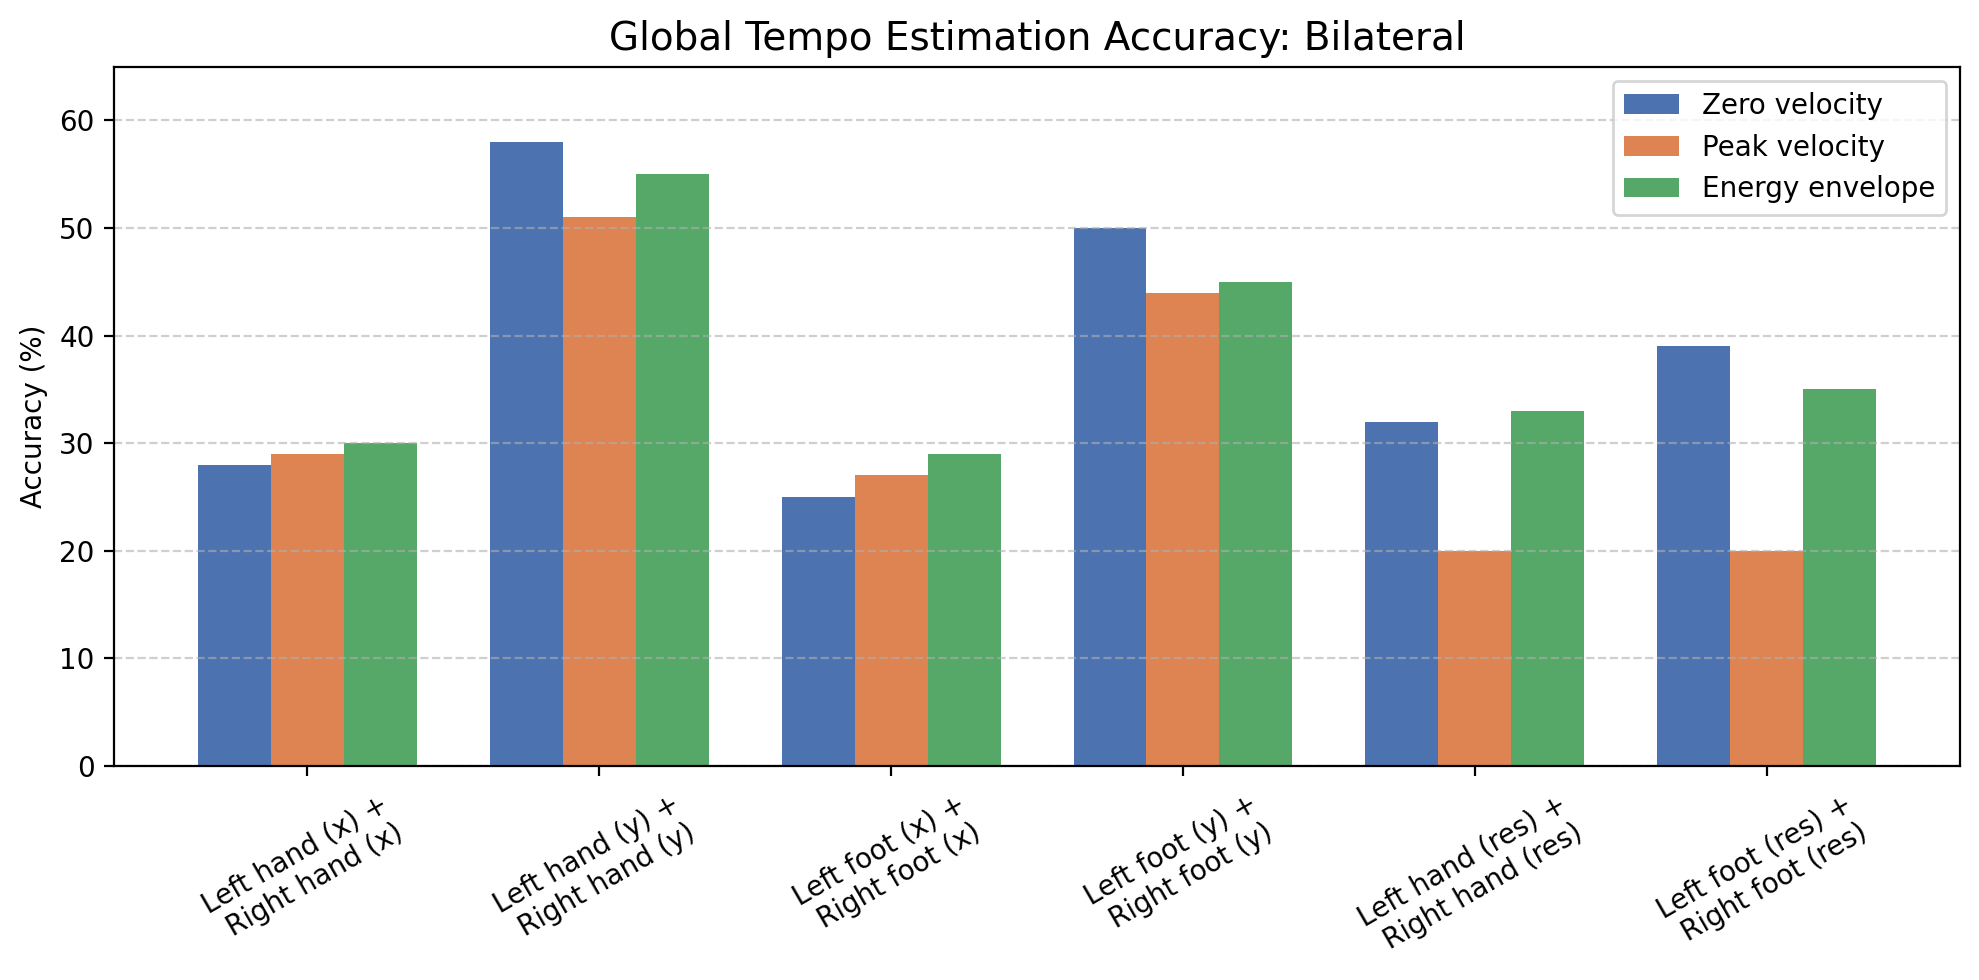

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# ==== Data ====
# segments_bilateral = [
#     "LH+RH (x)", "LH+RH (y)",
#     "LF+RF (x)", "LF+RF (y)",
#     "LH+RH (res)", "LF+RF (res)"
# ]

segments_bilateral = [
    "Left hand (x) + \nRight hand (x)",
    "Left hand (y) + \nRight hand (y)",
    "Left foot (x) + \nRight foot (x)",
    "Left foot (y) + \nRight foot (y)",
    "Left hand (res) + \nRight hand (res)",
    "Left foot (res) + \nRight foot (res)"
]

zero_uni_bilat = [28, 58, 25, 50, 32, 39]
peak_uni_bilat = [29, 51, 27, 44, 20, 20]
energy_uni_bilat = [30, 55, 29, 45, 33, 35]

# ==== Plot ====
x = np.arange(len(segments_bilateral))
width = 0.25

plt.figure(figsize=(10, 5), dpi=200)
plt.bar(x - width, zero_uni_bilat, width, label='Zero velocity', color='#4C72B0')
plt.bar(x, peak_uni_bilat, width, label='Peak velocity', color='#DD8452')
plt.bar(x + width, energy_uni_bilat, width, label='Energy envelope', color='#55A868')

plt.xticks(x, segments_bilateral, rotation=30, ha='center')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 65)
plt.title('Global Tempo Estimation Accuracy: Bilateral', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()

# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False, fontsize=12)
# plt.subplots_adjust(bottom=0.22)  

plt.tight_layout()
plt.show()


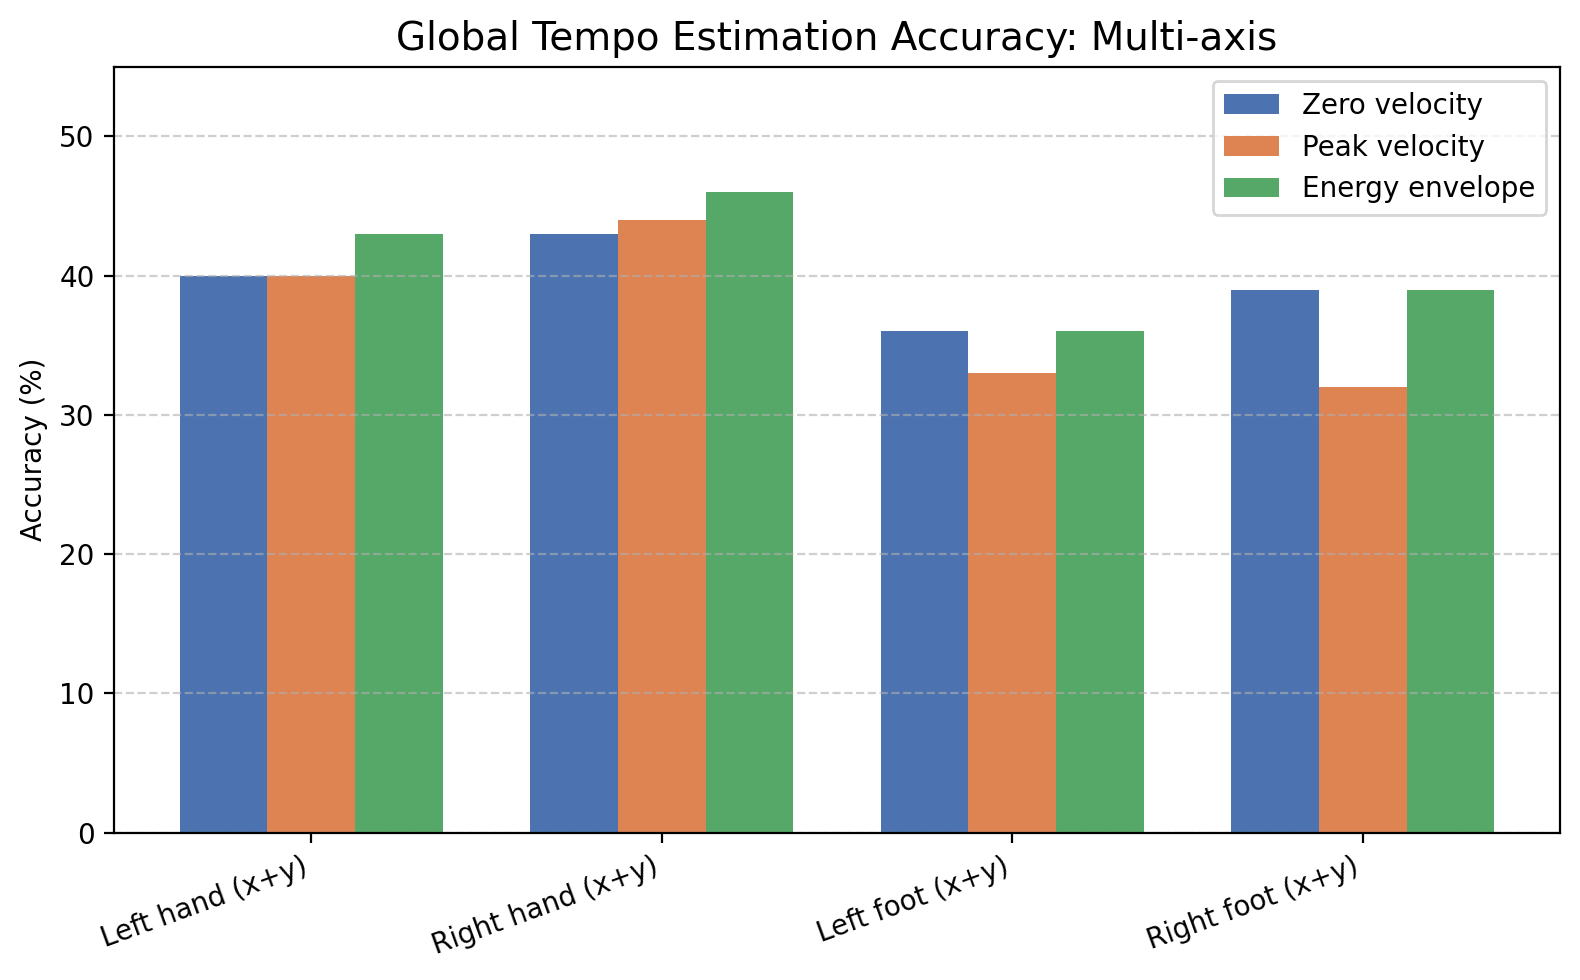

In [58]:
# ==== Data ====
segments_multiaxis = [
    "Left hand (x+y)",
    "Right hand (x+y)",
    "Left foot (x+y)",
    "Right foot (x+y)"
]

zero_uni_multi = [40, 43, 36, 39]
peak_uni_multi = [40, 44, 33, 32]
energy_uni_multi = [43, 46, 36, 39]

# ==== Plot ====
x = np.arange(len(segments_multiaxis))
width = 0.25

plt.figure(figsize=(8, 5), dpi=200)
plt.bar(x - width, zero_uni_multi, width, label='Zero velocity', color='#4C72B0')
plt.bar(x, peak_uni_multi, width, label='Peak velocity', color='#DD8452')
plt.bar(x + width, energy_uni_multi, width, label='Energy envelope', color='#55A868')

plt.xticks(x, segments_multiaxis, rotation=20, ha='right')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 55)
plt.title('Global Tempo Estimation Accuracy: Multi-axis', fontsize=14,)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


## Proposed

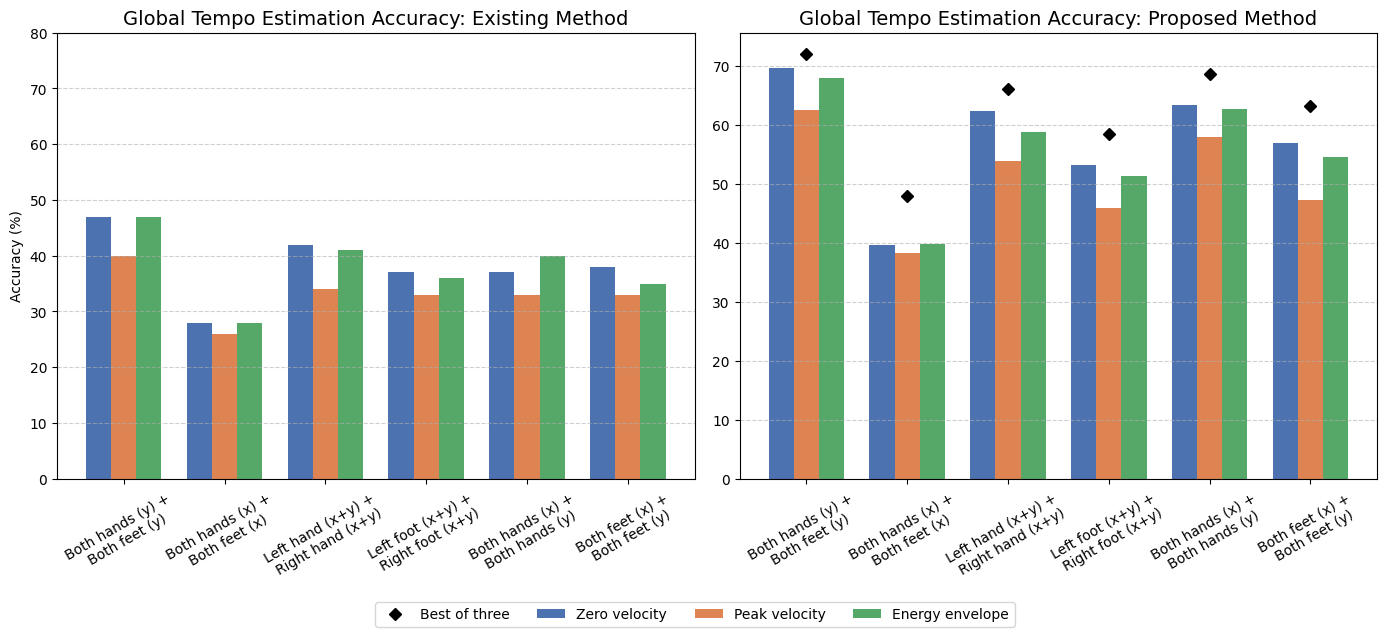

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# ==== Common settings ====
# segments = [
#     "BH(y)+BF(y)",
#     "BH(x)+BF(x)",
#     "LH(x+y)+RH(x+y)",
#     "LF(x+y)+RF(x+y)",
#     "BH(x)+BH(y)",
#     "BF(x)+BF(y)"
# ]

segments = [
    "Both hands (y) + \nBoth feet (y)",
    "Both hands (x) + \nBoth feet (x)",
    "Left hand (x+y) + \nRight hand (x+y)",
    "Left foot (x+y) + \nRight foot (x+y)",
    "Both hands (x) + \nBoth hands (y)",
    "Both feet (x) + \nBoth feet (y)"
]

# ==== Existing Method ====
zero_existing = [47, 28, 42, 37, 37, 38]
peak_existing = [40, 26, 34, 33, 33, 33]
energy_existing = [47, 28, 41, 36, 40, 35]

# ==== Weighted Method ====
zero_weighted = [69.6, 39.6, 62.34, 53.24, 63.31, 56.9]
peak_weighted = [62.57, 38.26, 53.91, 45.86, 57.87, 47.28]
energy_weighted = [68, 39.82, 58.76, 51.3, 62.64, 54.51]
best_weighted = [72, 48, 66, 58.39, 68.68, 63.24]

# ==== Plot ====
x = np.arange(len(segments))
width = 0.25

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# --- Existing ---
axs[0].bar(x - width, zero_existing, width, label='Zero velocity', color='#4C72B0')
axs[0].bar(x, peak_existing, width, label='Peak velocity', color='#DD8452')
axs[0].bar(x + width, energy_existing, width, label='Energy envelope', color='#55A868')
axs[0].set_title('Global Tempo Estimation Accuracy: Existing Method', fontsize=14, )
axs[0].set_xticks(x)
axs[0].set_xticklabels(segments, rotation=30, ha='center')
axs[0].set_ylabel('Accuracy (%)')
axs[0].set_ylim(0, 80)
axs[0].grid(axis='y', linestyle='--', alpha=0.6)

# --- Weighted ---
axs[1].bar(x - width, zero_weighted, width, label='Zero velocity', color='#4C72B0')
axs[1].bar(x, peak_weighted, width, label='Peak velocity', color='#DD8452')
axs[1].bar(x + width, energy_weighted, width, label='Energy envelope', color='#55A868')

# Add best-of-three as black diamonds (optional but clear)
axs[1].plot(x, best_weighted, 'kD', label='Best of three', markersize=6)

axs[1].set_title('Global Tempo Estimation Accuracy: Proposed Method', fontsize=14, )
axs[1].set_xticks(x)
axs[1].set_xticklabels(segments, rotation=30, ha='center')
axs[1].grid(axis='y', linestyle='--', alpha=0.6)

# --- Shared legend ---
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.001))     

plt.tight_layout()
plt.show()


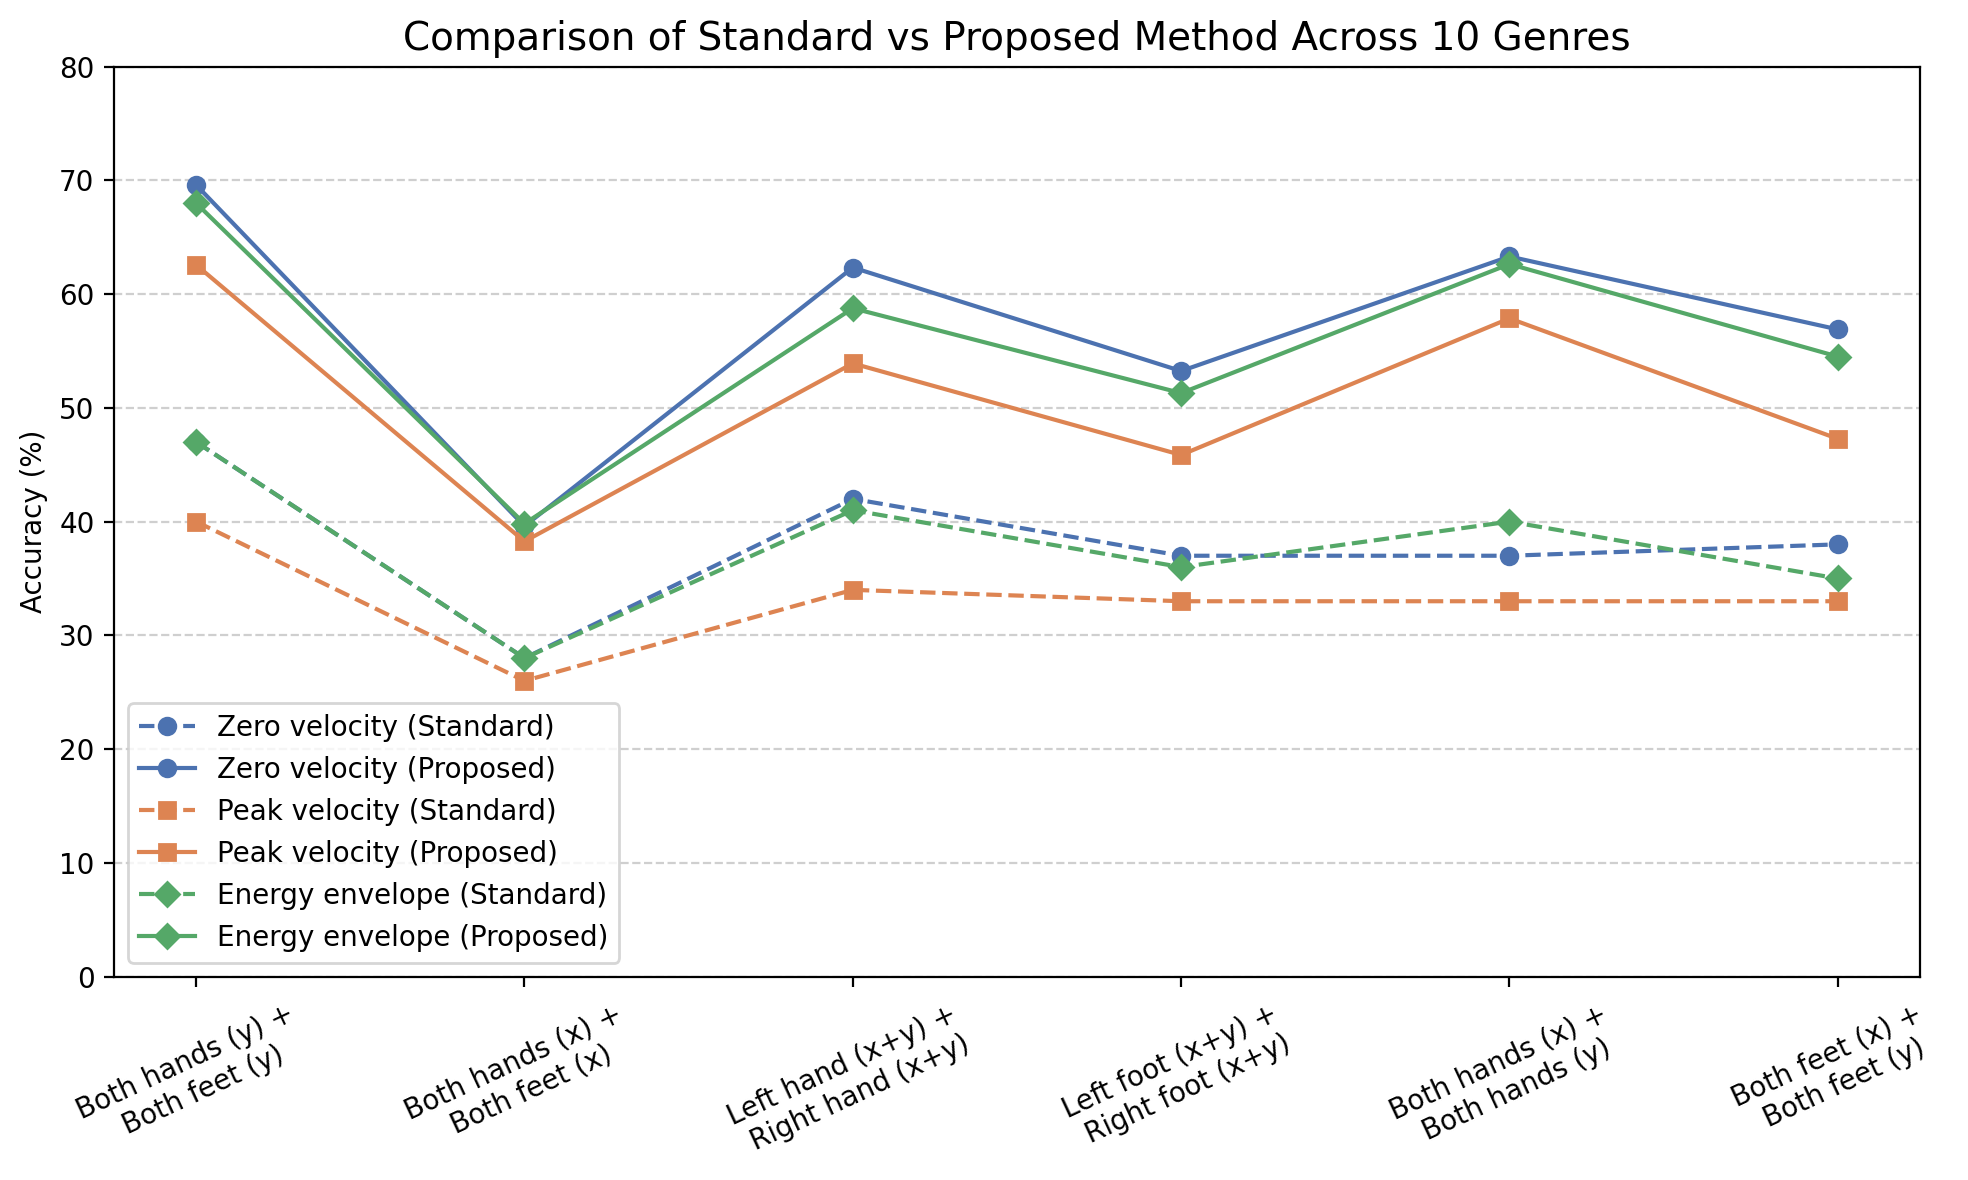

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# ==== Data ====
segments = [
    "Both hands (y) + \nBoth feet (y)",
    "Both hands (x) + \nBoth feet (x)",
    "Left hand (x+y) + \nRight hand (x+y)",
    "Left foot (x+y) + \nRight foot (x+y)",
    "Both hands (x) + \nBoth hands (y)",
    "Both feet (x) + \nBoth feet (y)"
]

# Standard
zero_existing = [47, 28, 42, 37, 37, 38]
peak_existing = [40, 26, 34, 33, 33, 33]
energy_existing = [47, 28, 41, 36, 40, 35]

# Weighted
zero_weighted = [69.6, 39.6, 62.34, 53.24, 63.31, 56.9]
peak_weighted = [62.57, 38.26, 53.91, 45.86, 57.87, 47.28]
energy_weighted = [68, 39.82, 58.76, 51.3, 62.64, 54.51]
best_weighted = [72, 48, 66, 58.39, 68.68, 63.24]

x = np.arange(len(segments))

plt.figure(figsize=(10, 6), dpi=200)

# ---- Zero Velocity ----
plt.plot(x, zero_existing, 'o--', color='#4C72B0', label='Zero velocity (Standard)')
plt.plot(x, zero_weighted, 'o-', color='#4C72B0', label='Zero velocity (Proposed)')

# ---- Peak Velocity ----
plt.plot(x, peak_existing, 's--', color='#DD8452', label='Peak velocity (Standard)')
plt.plot(x, peak_weighted, 's-', color='#DD8452', label='Peak velocity (Proposed)')

# ---- Energy Envelope ----
plt.plot(x, energy_existing, 'D--', color='#55A868', label='Energy envelope (Standard)')
plt.plot(x, energy_weighted, 'D-', color='#55A868', label='Energy envelope (Proposed)')

# ---- Best of three ----
# plt.plot(x, best_weighted, '^-', color = "red", label='Best of three (Proposed)')


plt.xticks(x, segments, rotation=25, ha='center')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 80)
plt.title('Comparison of Standard vs Proposed Method Across 10 Genres', fontsize=14, )
plt.grid(axis='y', linestyle='--', alpha=0.6)
# plt.legend(ncol=2, bbox_to_anchor=(0.5, 1.15), loc='upper center')
plt.legend()
plt.tight_layout()
plt.show()
